In [362]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import corner
plt.style.use('ggplot')

# Measuring the Temperature of Public Opinions with Thermometer Surveys

Thermometer surveys have a respondent place their opinion of a topic on a scale from 0 to 100 degrees, where indifference or no opinion is 50, a disfavorable opinion less than 50, and a favorable opinion greater than 50. This allows a convenient metric to quantify public opinion. 

The pre-processed **ANES** thermometer public opinion data is loaded here and scaled to values of -1 to 1 per feature. This helps to minimize any impact in the original dataset scaling. 

In [573]:
thermometer = pd.read_csv('ANES_thermometer_survey.csv')
#thermometer.iloc[:,3:] = MinMaxScaler(feature_range=(-1,1)).fit_transform(thermometer.iloc[:,3:])

X = MinMaxScaler(feature_range=(-1,1)).fit_transform(thermometer.iloc[:,3:])
y = thermometer['Party']

# Evaluating Liberalism and Conservatism Along Party Lines

As an example, below is the "Temperature" (or perception) of the words "Liberals" versus "Conservatives" in self described (independent, weak, and strong) **Democrats** and **Republicans**. 

The figures show that the alignment towards liberalism or conservatism does not necessarily follow a direct relationship with party lines. While increasing identification to Republicans is associated with a strong separation in temperature between terms Liberal and Conservative, the relation in Democrats is largely constant across . The large variance in all subsets being indicative that the dimensionality of the data is overly reduced.

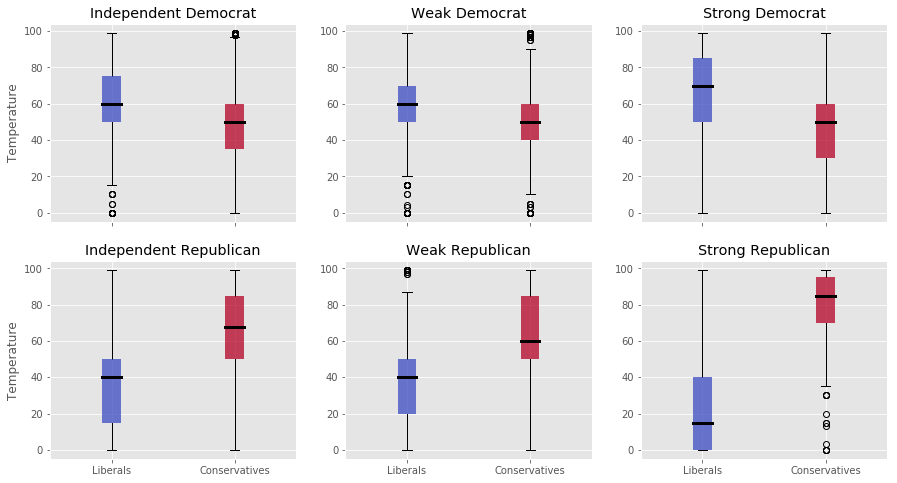

In [574]:
colors = plt.cm.coolwarm(np.linspace(0,1,2))
medianprops = dict(linestyle='-', linewidth=3, color='black')
boxprops = dict(linestyle='-', linewidth=0, alpha=0.75)

plt.figure(figsize=(15,8))
plt.subplot(2,3,1)
plt.title('Independent Democrat')
bp1 = plt.boxplot((thermometer[thermometer['Year'] >= 2012][thermometer['Party'] == 'Independent Democrat'][['VCF0211','VCF0212']]).as_matrix().astype(float), 
            labels=['', ''], patch_artist=True, boxprops=boxprops, medianprops=medianprops)#, bootstrap=1000)
plt.ylabel(r'Temperature')

plt.subplot(2,3,2)
plt.title('Weak Democrat')
bp2 = plt.boxplot((thermometer[thermometer['Year'] >= 2012][thermometer['Party'] == 'Weak Democrat'][['VCF0211','VCF0212']]).as_matrix().astype(float), 
            labels=['', ''], patch_artist=True, boxprops=boxprops, medianprops=medianprops)#, bootstrap=1000)

plt.subplot(2,3,3)
plt.title('Strong Democrat')
bp3 = plt.boxplot((thermometer[thermometer['Year'] >= 2012][thermometer['Party'] == 'Strong Democrat'][['VCF0211','VCF0212']]).as_matrix().astype(float), 
            labels=['', ''], patch_artist=True, boxprops=boxprops, medianprops=medianprops)#, bootstrap=1000)

plt.subplot(2,3,4)
plt.title('Independent Republican')
bp4 = plt.boxplot((thermometer[thermometer['Year'] >= 2012][thermometer['Party'] == 'Independent Republican'][['VCF0211','VCF0212']]).as_matrix().astype(float), 
            labels=['Liberals', 'Conservatives'], patch_artist=True, boxprops=boxprops, medianprops=medianprops)#, bootstrap=1000)
plt.ylabel(r'Temperature')

plt.subplot(2,3,5)
plt.title('Weak Republican')
bp5 = plt.boxplot((thermometer[thermometer['Year'] >= 2012][thermometer['Party'] == 'Weak Republican'][['VCF0211','VCF0212']]).as_matrix().astype(float), 
            labels=['Liberals', 'Conservatives'], patch_artist=True, boxprops=boxprops, medianprops=medianprops)#, bootstrap=1000)

plt.subplot(2,3,6)
plt.title('Strong Republican')
bp6 = plt.boxplot((thermometer[thermometer['Year'] >= 2012][thermometer['Party'] == 'Strong Republican'][['VCF0211','VCF0212']]).as_matrix().astype(float), 
            labels=['Liberals', 'Conservatives'], patch_artist=True, boxprops=boxprops, medianprops=medianprops)#, bootstrap=1000)

for bplot in (bp1, bp2, bp3, bp4, bp5, bp6):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
plt.show()

# Decomposing the Political Spectrum 

As the above shows, there may be an overlap between the standard party lines, and other axes may better represent the political identity of the public. To evaluate what these new axes are on the political spectrum, perform **Principal Component Analysis** (PCA) to find the axes that capture the largest variance in the thermometer data. We will use the number of dimensions that contain 95% of the explained variance.

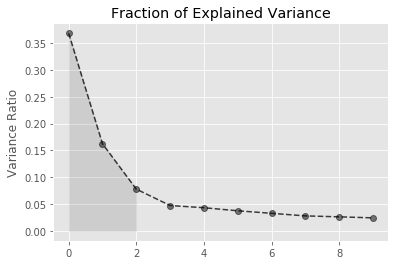

In [575]:
pc = PCA(n_components=10).fit(X)

plt.plot(pc.explained_variance_ratio_, 'o', color='black', alpha=0.5)
plt.plot(pc.explained_variance_ratio_, '--', color='black', alpha=0.75)
plt.fill_between([0,1,2], pc.explained_variance_ratio_[:3], color='black', alpha=0.1)
plt.title('Fraction of Explained Variance')
plt.ylabel('Variance Ratio')
plt.show()

pc = PCA(n_components=np.sum(pc.explained_variance_ratio_ >= 0.05)).fit(X)

Let's compare the distributions of the data in our new dimensions (shown in the figure below). It's immediately obvious that the distribution of these public opinions is not truly captured by a single modal normal distribution. There are multiple peaks that emerge, which when projected onto a single dimension (as shown by the 1D histograms) are largely obscured. 

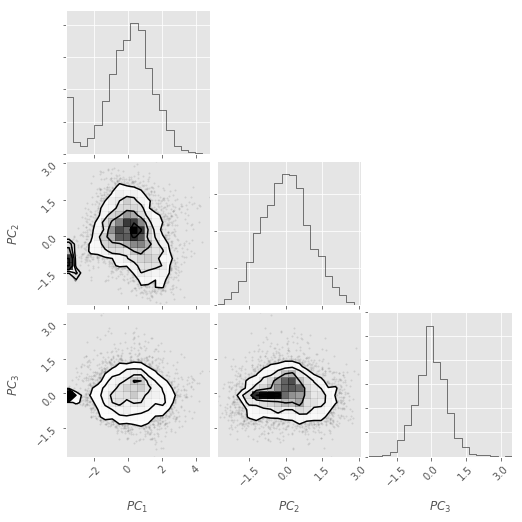

In [599]:
import corner
corner.corner(pc.transform(X), labels=[r'$PC_1$',r'$PC_2$', r'$PC_3$'])
plt.show()

# Identifying Structure in Decomposed Political Spectrum

As the data is somewhat noisy, we first generate a **Gaussian Mixture Model** (GMM) to estimate, using an Expectation-Maximization algorithm, the 100 most probable locations along the underlying distribution. From these GMM means k-means is used to extract political groups within the data. If we assume that the standard two-party system (using the 7 categories described previously), then the k-means method should roughly identify these features as distinct groups within the data.

In [580]:
n_states = 7
gmm = GaussianMixture(n_components=100).fit(pc.transform(X))
km = KMeans(n_clusters=n_states).fit(gmm.means_)

Once clusters are determined, a simple **k-Nearest Neighbors** (knn) algorithm can be used to identify what the corresponding political identity is for our k-means cluster centroids. We see that we find some of the categories, but some are repeated and others are missing.

In [582]:
knn = KNeighborsClassifier(n_neighbors=25).fit(X, y)
knn.predict(pc.inverse_transform(km.cluster_centers_))

array(['Strong Republican', 'Strong Democrat', 'Independent Democrat',
       'Weak Democrat', 'Independent Republican', 'Independent',
       'Strong Democrat'], dtype=object)

To better estimate the party lines within our new axes, we'll randomly sample positions about the k-means centroids, and see how unique these states are. As we see, doing so provides us with all states, but we find that these positions are largely overlapping with respect to **Independent**. In other words, the terms Democrat or Republicans (even of varying magnitude) can not sufficiently separate political identity. 

In [583]:
np.random.seed(42)
noisy_centroids = np.array([[km.cluster_centers_[k,:] + np.random.normal(scale=0.1, size=km.cluster_centers_.shape[1]) for i in range(100)] for k in range(n_states)])
[np.unique(knn.predict(pc.inverse_transform(noisy_centroids[k,:,:]))) for k in range(n_states)]

[array(['Independent Republican', 'Strong Republican', 'Weak Republican'], dtype=object),
 array(['Independent Democrat', 'Strong Democrat'], dtype=object),
 array(['Independent', 'Independent Democrat', 'Weak Democrat'], dtype=object),
 array(['Independent Democrat', 'Strong Democrat', 'Weak Democrat'], dtype=object),
 array(['Independent Republican', 'Strong Republican'], dtype=object),
 array(['Independent'], dtype=object),
 array(['Independent', 'Independent Democrat', 'Strong Democrat',
        'Weak Democrat'], dtype=object)]

We further visualize this analysis below, showing the sampling about the k-mean centroids and the associated party labels for each.

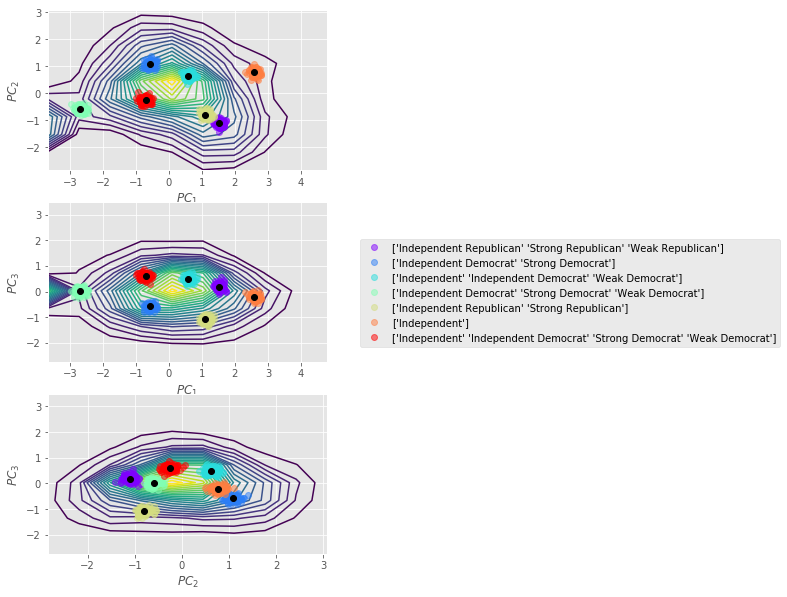

In [603]:
color = plt.cm.rainbow(np.linspace(0,1,n_states))
plt.figure(figsize=(5,10))

plt.subplot(3,1,1)
his,ext = np.histogramdd(pc.transform(X)[:,[0,1]])
plt.contour(his.T, 25, extent=[ext[0].min(), ext[0].max(), ext[1].min(), ext[1].max()])
for k in range(n_states):
    plt.plot(noisy_centroids[k,:,0], noisy_centroids[k,:,1], 'o', color=color[k], alpha=0.5, label=np.unique(knn.predict(pc.inverse_transform(noisey_centroids[k,:,:]))))
plt.plot(km.cluster_centers_[:,0], km.cluster_centers_[:,1], 'o', color='black')
plt.xlabel(r'$PC_1$')
plt.ylabel(r'$PC_2$')

plt.subplot(3,1,2)
his,ext = np.histogramdd(pc.transform(X)[:,[0,2]])
plt.contour(his.T, 25, extent=[ext[0].min(), ext[0].max(), ext[1].min(), ext[1].max()])
for k in range(n_states):
    plt.plot(noisy_centroids[k,:,0], noisy_centroids[k,:,2], 'o', color=color[k], alpha=0.5, label=np.unique(knn.predict(pc.inverse_transform(noisey_centroids[k,:,:]))))
plt.plot(km.cluster_centers_[:,0], km.cluster_centers_[:,2], 'o', color='black')
plt.legend(bbox_to_anchor=(1.1, 0.8))
plt.xlabel(r'$PC_1$')
plt.ylabel(r'$PC_3$')

plt.subplot(3,1,3)
his,ext = np.histogramdd(pc.transform(X)[:,[1,2]])
plt.contour(his.T, 25, extent=[ext[0].min(), ext[0].max(), ext[1].min(), ext[1].max()])
for k in range(n_states):
    plt.plot(noisy_centroids[k,:,1], noisy_centroids[k,:,2], 'o', color=color[k], alpha=0.5, label=np.unique(knn.predict(pc.inverse_transform(noisey_centroids[k,:,:]))))
plt.plot(km.cluster_centers_[:,1], km.cluster_centers_[:,2], 'o', color='black')
plt.xlabel(r'$PC_2$')
plt.ylabel(r'$PC_3$')
plt.show()